# Проект по принятию решений в бизнесе на основе данных

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.
План работы включаеит в себя следующие этапы:
- Применение фреймворков ICE и RICE для приоритизации гипотез, анализ различий
- Построение графика кумулятивной выручки по группам
- Построение графика кумулятивного среднего чека по группам
- Построение графика относительного изменения кумулятивного среднего чека группы B к группе A
- Построение графика кумулятивного среднего количества заказов на посетителя по группам
- Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
- Построение точечного графика количества заказов по пользователям
- Подсчет перцентилей количества заказов на пользователя и стоимости заказов
- Выбор границы для определения аномальных пользователей
- Построение точечного графика стоимостей заказов
- Подсчет статистической значимости для всех метрик по "сырым" и "очищенным" данным
- Формулировка выводов и предположений
- Принятие решения по результатам проведенного теста и его обоснование

## Загрузка и изучение данных

In [1]:
#выгрузка всех необходимых библеотек
import pandas as pd
import datetime as dt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#вывод таблицы с гипотезами
try:
    hypothesis = pd.read_csv('C:/Users/Любовь/Downloads/hypothesis.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    
pd.set_option('display.max_colwidth', None) #сняла ограничение с ширины столбцов

hypothesis.info()
hypothesis #вывод таблицы с гипотезами

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
try:
    orders, visitors = (
        pd.read_csv('C:/Users/Любовь/Downloads/orders.csv'),
        pd.read_csv('C:/Users/Любовь/Downloads/visitors.csv'))
except:
    orders, visitors = (
        pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv'))

orders.info()
orders.head() #вывод таблицы с заказами

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
visitors.info()
visitors.head() #вывод таблицы с посетителями

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**Промежуточные выводы:** в данных нет пропущенных значений, однако в таблицах с посетителями и заказами есть проблема с типом данных в столбце data. На следующем этапе стоит исправить это, а также проверить таблицы на наличие дубликатов и привести все названия к нижнему регистру.

## Предобработка данных

In [5]:
#преобразование стиля названий
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})

In [6]:
#изменение типа данных
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [7]:
orders.duplicated().sum()

0

In [8]:
visitors.duplicated().sum()

0

In [9]:
#проверяем наличие пользователей, оказавшихся в двух группах сразу
A = orders[orders['group'] == 'A']['visitor_id']
B = orders[orders['group'] == 'B']['visitor_id']
AB = orders.query('visitor_id in @A and visitor_id in @B')
print(
    'Доля пользователей, оказавшихся в двух группах сразу:', 
    round(AB['visitor_id'].nunique() / orders['visitor_id'].nunique(), 4)
)

Доля пользователей, оказавшихся в двух группах сразу: 0.0563


In [10]:
orders = orders.query('visitor_id not in @AB["visitor_id"]')
print('Осталось пользователей:', orders['visitor_id'].nunique())

Осталось пользователей: 973


**Промежуточные выводы**: изменили тип данных в столбце data, преобразовали стили названий и проверили проверку на дубликаты. Также выявили пользователей, оказавшихся в двух группах сразу - их доля оказалась небольшой - 5.6%, поэтому их исключили из рассмотрения. После предобработки можно приступать к анализу.

## Приоритизация гипотез

In [11]:
hypothesis['ice'] = (hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']).round(2)
hypothesis.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [12]:
hypothesis['rice'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


**Промежуточные выводы:** при применении фреймворка RICE вместо ICE приоритет гипотез несколько изменился. Так, например, гипотеза №7 оказалась в лидерах - это связано с ее высоким охватом пользователей, а №8, наоборот, опустилась до 5 места в списке, так как она хоть и имеет сильное влияние, но оказывает его на узкий круг лиц. В итоге, топ-3 гипотез у ICE включают №8, 0 и 7, а у RICE - №7, 2 и 0.

## Анализ А/В-теста

### Построение графика кумулятивной выручки по группам

In [13]:
#создание массива уникальных пар значений дат и групп теста
date_groups = orders[['date', 'group']].drop_duplicates()

In [14]:
#получение агрегированных кумулятивных данных по дням о заказах и о посетителях
orders_aggregated = date_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date':'max', 'group':'max', 'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}), axis=1).sort_values(by=['date', 'group'])

visitors_aggregated = date_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1).sort_values(by=['date', 'group'])

In [15]:
#объединяем кумулятивные данные в одной таблице
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


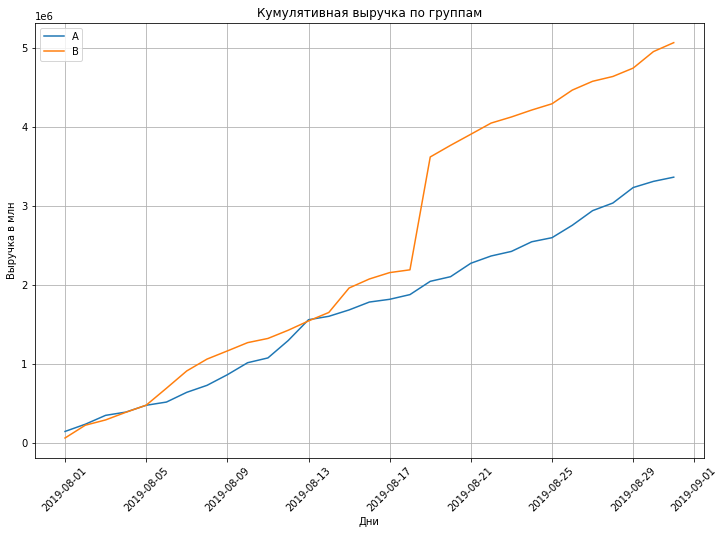

In [16]:
#кумулятивная выручка по дням по группам
cumulative_revenue_A = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]
cumulative_revenue_B = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

#строим график
plt.figure(figsize=(12,8))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label = 'A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label = 'B')

plt.grid()
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дни')
plt.ylabel('Выручка в млн')
plt.xticks(rotation=45)
plt.legend()
plt.show();

**Промежуточные выводы:** из графика видно, что кумулятивные выручки клиентов из группы В и А растут на протяжении всего времени, что, безусловно, хорошо. Выручка не сильно отличалась между группами до 18 августа. В этот день произошел резкий скачок выручки у группы В. Это может быть связано с каким-то крупным заказом или скачком заказов в целом - эти аномалии могли исказить результат.

### Построение графика кумулятивного среднего чека по группам

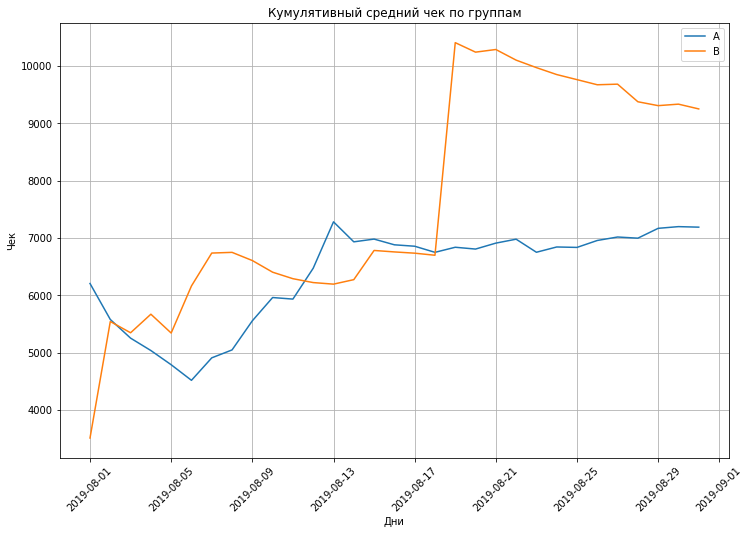

In [17]:
plt.figure(figsize=(12,8))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')

plt.grid()
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дни')
plt.ylabel('Чек')
plt.xticks(rotation=45)
plt.legend();

**Промежуточные выводы:** значения среднего чека нестабильны у обеих групп. Ближе к концу наблюдения у группы А становится более плавный график и значения выравниваются. А вот у гпуппы В и на этом графике виден сильный скачок 18 августа - значит, он связан с каким-то крупным заказом. Этот аномальный заказ сказался на результатах, поэтому для выравнивания значений группе В нужно больше данных.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

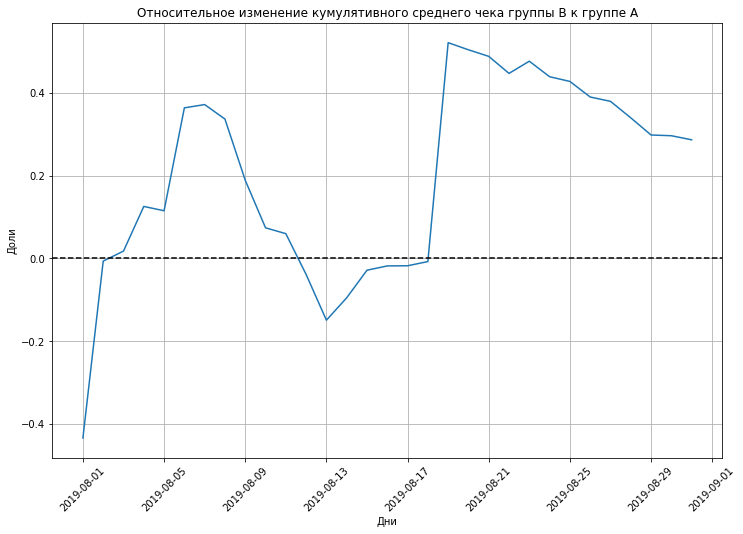

In [18]:
#собираем данные в один датафрейм
cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

#строим график
plt.figure(figsize=(12,8))
plt.plot(
    cumulative_revenue['date'], 
    (cumulative_revenue['revenueB']/cumulative_revenue['ordersB'])/(cumulative_revenue['revenueA']/cumulative_revenue['ordersA']) - 1)

plt.grid()
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дни')
plt.ylabel('Доли')
plt.xticks(rotation=45)

#добавляем ось 
plt.axhline(y=0, color='black', linestyle='--');

**Промежуточные выводы:** на графики видны сильные скачки, что еще раз подтверждает теорию об аномалиях. Почти на протяжении всего времени группа В лидировала в среднем чеке, однако 1 и 13 августа значения "просели" на 40 и 10 % соответственно относительно группы А.

### Построение графика кумулятивного среднего количества заказов на посетителя по группам

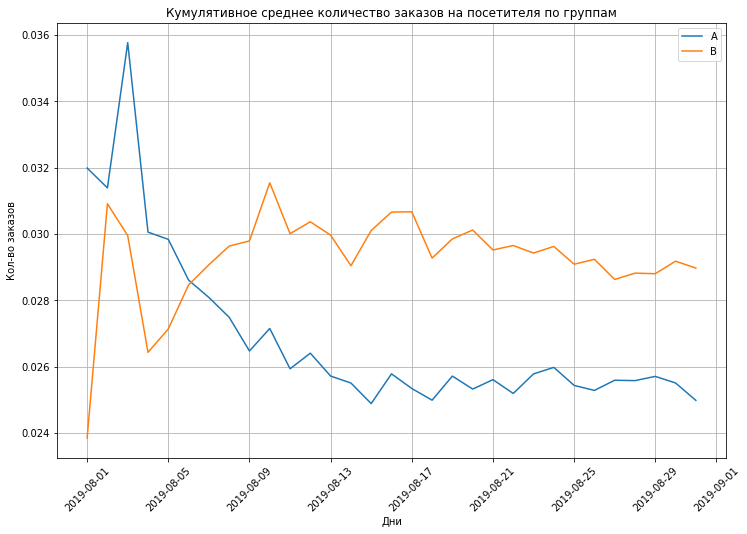

In [19]:
#считаем среднее число заказов на посетителя и делим по группам
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']

#строим график
plt.figure(figsize=(12,8))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')

plt.grid()
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.xticks(rotation=45)
plt.legend();

**Промежуточные выводы:** после резких колебаний в начале, к середине теста оба графика выровнялись около некоторых значений - группа В показывает лучшие результаты в среднем количестве заказов на посетителя.

### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

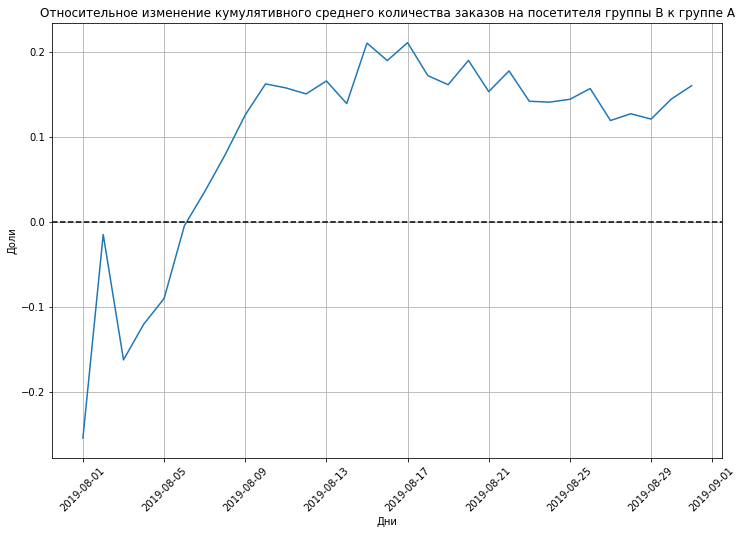

In [20]:
#собираем данные в один датафрейм
cumulative_conversion = cumulative_data_A.merge(
    cumulative_data_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

#строим график
plt.figure(figsize=(12,8))
plt.plot(cumulative_conversion['date'], cumulative_conversion['conversionB']/cumulative_conversion['conversionA']-1)

plt.grid()
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дни')
plt.ylabel('Доли')
plt.xticks(rotation=45)

#добавляем ось
plt.axhline(y=0, color='black', linestyle='--');

**Промежуточные выводы:** из графика видно, что в первые дни показатели группы В были хуже на 10-20% относительно группы А. Однако после 6 августа среднее количество заказов группы В превосходило группу А, даже достигнув в какой-то момент разницы в 20%. Однако выбор делать рано, пока в данных возможны аномалии.

### Построение точечного графика количества заказов по пользователям

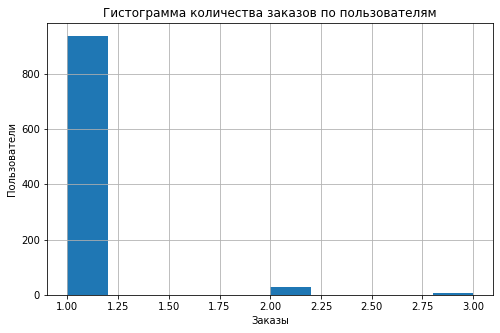

In [21]:
#считаем количество заказов по пользователям
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users.columns = ['visitor_id', 'orders']

#строим гистограмму
plt.figure(figsize=(8, 5))
plt.hist(orders_by_users['orders'])

plt.grid()
plt.title('Гистограмма количества заказов по пользователям')
plt.xlabel('Заказы')
plt.ylabel('Пользователи');

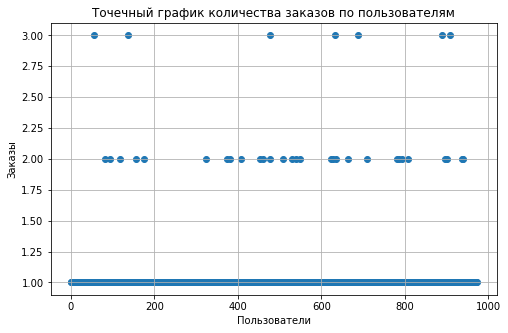

In [22]:
#строим точечную диаграмму
x_values = pd.Series(range(0, len(orders_by_users)))
plt.figure(figsize=(8, 5))
plt.scatter(x_values, orders_by_users['orders'])

plt.grid()
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Заказы');

**Промежуточные выводы:** по графикам видно, что большинство посетителей делают не больше 1-2 заказов. Однако отсечь аномальные значения по точечному графику трудно - ведь "на глаз" не определить 1-5% от всех данных. Для выбора границы аномальных пользователей обратимся к перцентилям. 

### Подсчет 95-й и 99-й перцентилей количества заказов на пользователя и выбор границы для определения аномальных пользователей

In [23]:
np.percentile(orders_by_users['orders'], [95,99])

array([1., 2.])

**Промежуточные выводы:** итак, мы видим, что меньше 5% пользователей совершают больше 1 заказа. А больше 2 заказов совершал лишь 1% от всех испытуемых. Итого, для определения аномальных пользователей разумно выбрать границу в 2 заказа - 1% исключаются из рассмотрения.

### Построение точечного графика стоимостей заказов

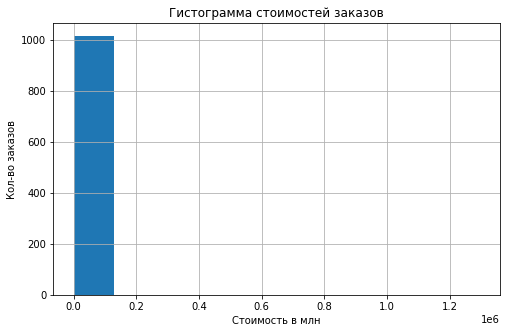

In [24]:
#строим гистограмму
plt.figure(figsize=(8,5))
plt.hist(orders['revenue'])

plt.grid()
plt.title('Гистограмма стоимостей заказов')
plt.xlabel('Стоимость в млн')
plt.ylabel('Кол-во заказов');

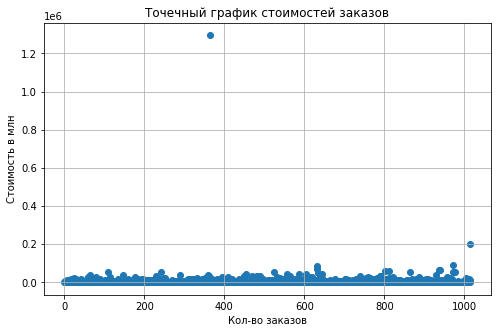

In [25]:
#строим точечную диаграмму
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(8, 5))
plt.scatter(x_values, orders['revenue'])

plt.grid()
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Кол-во заказов')
plt.ylabel('Стоимость в млн');

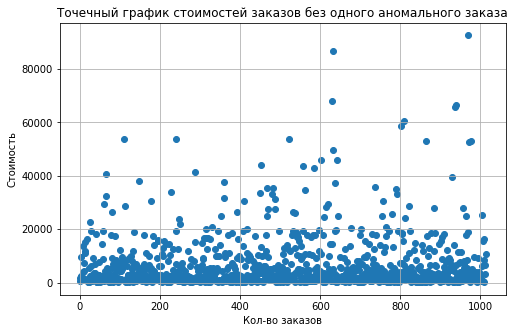

In [26]:
#строим точечную диаграму без одного аномального значения
x_values = pd.Series(range(0, len(orders.query('revenue <= 200000')['revenue'])))
plt.figure(figsize=(8, 5))
plt.scatter(x_values, orders.query('revenue <= 200000')['revenue'])

plt.grid()
plt.title('Точечный график стоимостей заказов без одного аномального заказа')
plt.xlabel('Кол-во заказов')
plt.ylabel('Стоимость');

**Промежуточные выводы:** итак, по графикам обнаружился тот самый заказ, из-за которого происходил резкий скачок во всех графиках - кто-то совершил покупку больше, чем на 1,2 миллиона рублей. В то время, как остальные пользователи не переступали отметку в 200 тысяч рублей. Исключив этого пользователя из рассмотрения, стало видно, что большая часть покупателей не осущетсвляют заказы дороже 40 тысяч.  

### Подсчет 95-й и 99-й перцентилей стоимости заказов и выбор границы для определения аномальных заказов

In [27]:
np.percentile(orders['revenue'], [95,99])

array([26785., 53904.])

**Промежуточные выводы:** по результатам видно, что меньше 5% заказов оказались дороже 26785. А заказы дороже 53904 рублей попадались лишь в 1% случаев. Итого, для определения аномальных заказов разумно выбрать границу в 40000 рублей - от 1 до 5 % исключаются из рассмотрения.

### Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы. 

Нулевая: различий в среднем количестве заказов между группами нет. 

Альтернативная: различия в среднем между группами есть.

Выбранный уровень статистической значимости: alpha=0.05

В наших данных встречаются выбросы, а данные распределены ненормально, поэтому для проверки гипотез воспользуемся непараметрическим тестом Уилкоксона-Манна-Уитни.

In [28]:
#подготовка данных о посетителях
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg({'date':'max', 'visitors_per_date_A':'sum'}), 
    axis=1)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg({'date':'max', 'visitors_per_date_B':'sum'}), 
    axis=1)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

In [29]:
#подготовка данных о заказах
orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id':'nunique', 'revenue':'sum'}))
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg({'date':'max', 'orders_per_date_A':'sum', 'revenue_per_date_A':'sum'}),
    axis=1).sort_values(by=['date'])
orders_A_cummulative.columns = ['date', 'orders_cummulative_A', 'revenue_cummulative_A']

orders_B_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id':'nunique', 'revenue':'sum'}))
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg({'date':'max', 'orders_per_date_B':'sum', 'revenue_per_date_B':'sum'}),
    axis=1).sort_values(by=['date'])
orders_B_cummulative.columns = ['date', 'orders_cummulative_B', 'revenue_cummulative_B']

In [30]:
#создадим переменные, в которых будут пользователями и число совершённых заказов 
orders_by_users_A = orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users_A.columns = ['visitor_id', 'orders']

orders_by_users_B = orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users_B.columns = ['visitor_id', 'orders']

In [31]:
#создадим переменные по группам с числом заказов определённого пользователя, в том числе нулем
sampleA = pd.concat(
    [orders_by_users_A['orders'], 
    pd.Series(0, index=np.arange(
        cumulative_data[cumulative_data['group'] == 'A']['visitors'].max()-len(orders_by_users_A['orders'])), name='orders')],
    axis=0
)

sampleB = pd.concat(
    [orders_by_users_B['orders'],
    pd.Series(0, index=np.arange(
        cumulative_data[cumulative_data['group'] == 'B']['visitors'].max()-len(orders_by_users_B['orders'])), name='orders')],
    axis=0
)

In [32]:
#посчитаем статистическую значимость по "сырым" данным
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('относительный прирост В к А:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
относительный прирост В к А: 0.160


**Промежуточные выводы:** при уровне значимости alpha=0.05 можно отвергнуть нулевую гипотезу, так как p-value меньше alpha - а значит, в данных есть статистически значимые различия. Однако при alpha=0.01 такой вывод уже сделать нельзя. Относительный прирост группы В составил 16%. На мой взгляд, с таким выигрышем относительно группы А, логично выбрать уровень значимости в 5% и считать, что статистические различия в среднем количестве заказов на посетителя между группами есть. 

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы.

Нулевая: различий в среднем чеке заказа между группами нет.

Альтернативная: различия в среднем чеке между группами есть.

In [33]:
#посчитаем статистическую значимость по "сырым" данным
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))
print('относительный прирост В к А:', "{0:.3f}".format(orders[orders['group'] == 'B']['revenue'].mean()/orders[orders['group'] == 'A']['revenue'].mean() - 1))

p-value: 0.829
относительный прирост В к А: 0.287


**Промежуточные выводы:** нельзя отвергнуть нулевую гипотезу, так как p-value значительно больше alpha - значит, в данных нет статистически значимых различий. Относительный прирост группы В составил 28,7%.

### Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [34]:
#сделаем срез с аномальными пользователями
users_with_many_orders = pd.concat(
    [orders_by_users_A[orders_by_users_A['orders'] > 3]['visitor_id'],
    orders_by_users_B[orders_by_users_B['orders'] > 3]['visitor_id']],
    axis=0)

users_with_expensive_orders = orders[orders['revenue'] > 40000]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('всего аномальных пользователей:', abnormal_users.shape[0])

всего аномальных пользователей: 23


In [35]:
#посчитаем статистическую значимость по "очищенным" данным
sampleA_filtered = pd.concat(
    [orders_by_users_A[np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))]['orders'], 
    pd.Series(0, index=np.arange(
        cumulative_data[cumulative_data['group'] == 'A']['visitors'].max()-len(orders_by_users_A['orders'])), name='orders')],
    axis=0
)

sampleB_filtered = pd.concat(
    [orders_by_users_B[np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))]['orders'],
    pd.Series(0, index=np.arange(
        cumulative_data[cumulative_data['group'] == 'A']['visitors'].max()-len(orders_by_users_A['orders'])), name='orders')],
    axis=0
)
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]))
print('относительный прирост В к А:', "{0:.3f}".format(sampleB_filtered.mean()/sampleA_filtered.mean() - 1))

p-value: 0.005
относительный прирост В к А: 0.184


**Промежуточные данные:** по "очищенным" данным при обоих уровнях значимости (0,05 и 0,01) p-value меньше alpha. А значит склоняемся в пользу альтернативной гипотезы, что статистически значимые различия между данными есть. По результатам, очищенным от аномальных значений, относительный прирост группы В составил 18.4%.

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [36]:
#посчитаем статистическую значимость по "очищенным" данным
revenue_A_filtered = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']
revenue_B_filtered = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(revenue_A_filtered, revenue_B_filtered)[1]))
print('относительный прирост В к А:', "{0:.3f}".format(revenue_B_filtered.mean() / revenue_A_filtered.mean() - 1))

p-value: 0.831
относительный прирост В к А: 0.051


**Промежуточные выводы:** p-value так и остался значительно больше alpha, а значит, нельзя отвергнуть нулевую гипотезу о том, что в данных нет статистически значимых различий. А вот относительный прирост группы В существенно уменьшился в сравнении с сырыми данными - с 28,7% до 5%. Аномально дорогие заказы сильно повлияли на разницу в среднем чеке у групп.

## Общие выводы

В процессе исследования задачи, поставленной заказчиком, были выполнены следующие этапы, а также сделаны выводы и составлены рекомендации по ним:
1. Применены фреймворки ICE и RICE для приоритизации гипотез.

В результате, если охват пользователей учитывать нет необходимости, то в первую очередь стоят следующие гипотезы:
   - Запустить акцию, дающую скидку на товар в день рождения;
   - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
   - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

При учете охвата пользователей приоритет изменился:
   - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
   - Добавить блоки рекомендаций товаров на сайт интернет-магазина, чтобы повысить конверсию и средний чек заказа;
   - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
   
2. Проведен анализ А/B-теста
- Графики кумулятиывных данных стабильно показывают превосходство группы В, однако на них видны резкие, аномальные скачки;
- Статистически значимые отличия в среднем количестве заказов между группами есть. По результатам, очищенным от аномальных значений, относительный прирост группы В к А составил целых 18.4%;
- В данных о среднем чеке заказа нет статистически значимых различий  между группами. А относительный прирост группы В к А по "очищенным" данным составил всего 5%.

3. По результатам проведенного теста я приняла решение остановить его и зафиксировать победу группы В. Проанализировав результаты можно заметить, что группа В стабильно занимала лидирующую позицию. Несмотря на значительные выбросы в данных, связанные с аномально дорогими заказами, "сырые" и "очищенные" данные дали нам один результат - хотя в среднем чеке и не наблюдалось особой разницы, было выявлено статистически значимое отличие между группами в количестве заказов на посетителя.